In [ ]:
# ✅ STEP 1: Install Required Libraries
!pip install -U datasets huggingface_hub fsspec pandas scikit-learn matplotlib seaborn numpy tensorflow


  Using cached numpy-2.3.2-cp311-cp311-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [ ]:
# ✅ STEP 2: Import Libraries
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.utils import class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# ✅ STEP 3: Load Dataset
dataset = load_dataset("sonnh-tech1/cic-ids-2017", "binary")
df = dataset["train"].to_pandas()

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/92.8M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/108M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/107M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2522362 [00:00<?, ? examples/s]

In [ ]:
# ✅ Step: Limit & balance dataset to 3k benign + 3k attack
benign_df = df[df['Label'] == 0].sample(3000, random_state=42)
attack_df = df[df['Label'] == 1].sample(3000, random_state=42)
df_balanced = pd.concat([benign_df, attack_df]).sample(frac=1, random_state=42).reset_index(drop=True)

# ✅ Step: Add small label noise (1.5%) to simulate realistic data
import random
flip_indices = random.sample(list(df_balanced.index), int(0.015 * len(df_balanced)))  # 1.5% noise
df_balanced.loc[flip_indices, 'Label'] = 1 - df_balanced.loc[flip_indices, 'Label']

# ✅ Step: Prepare features and scale
X = df_balanced.drop(['Label', 'LabelMap'], axis=1)
y = df_balanced['Label']

X_numeric = X.select_dtypes(include=['int64', 'float64'])
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
# ✅ ANN: Reduced capacity, high dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(48, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(24, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

'''history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=60,                # 👈 keep this
                    batch_size=256,           # 👈 keep this
                    callbacks=[early_stop],
                    verbose=1)'''
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=60,
                    batch_size=256,
                    verbose=1)


Epoch 1/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9514 - loss: 0.1843 - val_accuracy: 0.9548 - val_loss: 0.1489
Epoch 2/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9590 - loss: 0.1517 - val_accuracy: 0.9571 - val_loss: 0.1469
Epoch 3/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9526 - loss: 0.1756 - val_accuracy: 0.9548 - val_loss: 0.1476
Epoch 4/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9538 - loss: 0.1708 - val_accuracy: 0.9571 - val_loss: 0.1470
Epoch 5/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9513 - loss: 0.1605 - val_accuracy: 0.9571 - val_loss: 0.1470
Epoch 6/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9545 - loss: 0.1668 - val_accuracy: 0.9560 - val_loss: 0.1487
Epoch 7/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9545 - loss: 0.1810 - val_accuracy: 0.9571 - val_loss: 0.1482
Epoch 8/60
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9517 - loss: 0.1752 - val_accuracy: 0.9595 - val_loss:

In [ ]:
# ✅ Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("✅ Final Accuracy:", accuracy_score(y_test, y_pred))
print("✅ ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))




57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
✅ Final Accuracy: 0.96
✅ ROC-AUC: 0.9827971910556257

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       904
           1       0.96      0.96      0.96       896

    accuracy                           0.96      1800
   macro avg       0.96      0.96      0.96      1800
weighted avg       0.96      0.96      0.96      1800


📊 Confusion Matrix:
 [[867  37]
 [ 35 861]]


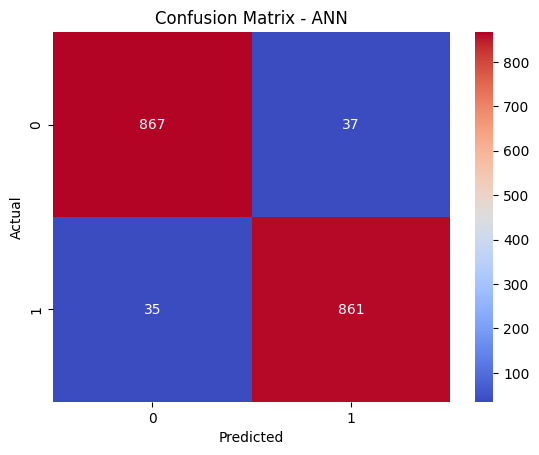

In [ ]:
# ✅ Confusion Matrix Heatmap
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN')
plt.show()

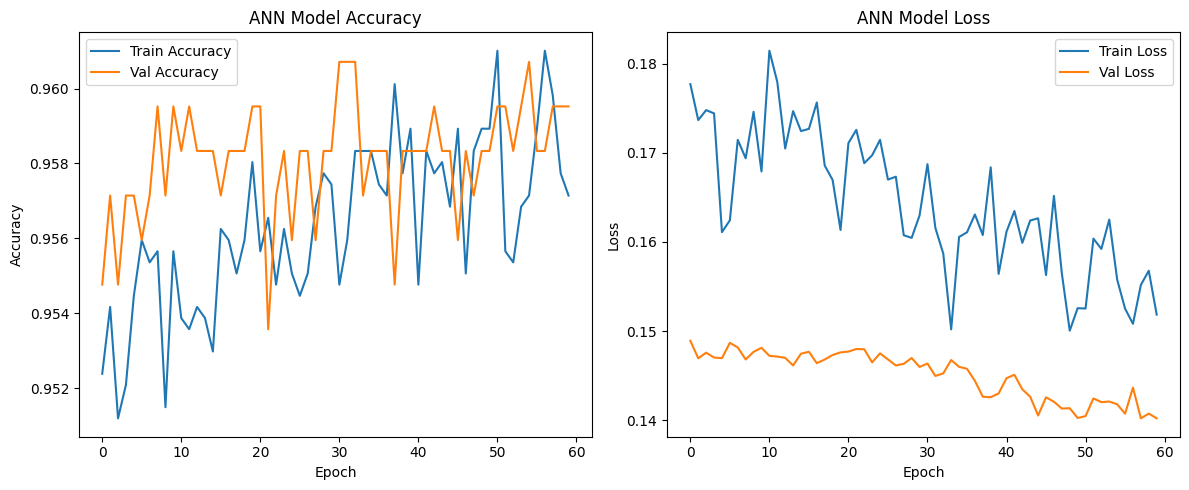

In [ ]:
# ✅ STEP 11: Plot Training History
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()